In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from typing import TypedDict,Annotated,TypedDict

class State(TypedDict):
    graph_state: str

In [3]:
def node1(state:State):
    print('---N1---')
    return {'graph_state': state['graph_state']+'I am'}

def node2(state):
    print('---N2---')
    return {'graph_state': state['graph_state']+'happy'}

def node3(state):
    print('---N3---')
    return {'graph_state': state['graph_state']+'sad'}


In [4]:
import random
from typing import Literal

def mode(state)->Literal['node2','node3']:
    current_state = state['graph_state']

    if random.random() <.5:
        return 'node2'
    return 'node3'

In [5]:
from langgraph.graph import StateGraph,START,END

builder= StateGraph(State)

builder.add_node('node1',node1)
builder.add_node('node2',node2)
builder.add_node('node3',node3)

builder.add_edge(START,'node1')
builder.add_conditional_edges('node1',mode)
builder.add_edge('node2',END)
builder.add_edge('node3',END)

graph= builder.compile()


In [6]:
graph.invoke({'graph_state':'Hi I am Rt'})

---N1---
---N2---


{'graph_state': 'Hi I am RtI amhappy'}

# Chain

In [7]:
from langchain_core.messages import HumanMessage,AIMessage,SystemMessage
from langchain_groq import ChatGroq

In [ ]:
llm = ChatGroq(model='llama-3.1-8b-instant')

In [9]:
result = llm.invoke('hello how are you?')

In [10]:
result.content

"Hello. I'm functioning properly, thanks for asking. How can I assist you today?"

In [11]:
def multiply(a:int ,b:int)-> int:
    '''
    Multiply a and b

    Args:
    a: First int
    b: Second int
    '''
    return a*b

def addition(a:int ,b:int)-> int:
    '''
    Addition a and b

    Args:
    a: First int
    b: Second int
    '''
    return a+b


def division(a:int ,b:int)-> float:
    '''
    Divide a by b

    Args:
    a: First int
    b: Second int
    '''
    return a/b

llm_with_tool = llm.bind_tools([multiply,addition,division])

In [12]:
llm_with_tool.invoke([HumanMessage(content='Hello')])

AIMessage(content="I'm happy to assist you with the given functions. What would you like to do first?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 357, 'total_tokens': 377, 'completion_time': 0.046009861, 'completion_tokens_details': None, 'prompt_time': 0.038264976, 'prompt_tokens_details': None, 'queue_time': 0.049711114, 'total_time': 0.084274837}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_1151d4f23c', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c224f-cae8-70e0-afb0-a00583d5891e-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 357, 'output_tokens': 20, 'total_tokens': 377})

In [13]:
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode,tools_condition
class MessegeState(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

In [14]:
from langgraph.graph import MessagesState
class State(MessagesState):
    pass 

In [21]:
from langgraph.checkpoint.memory import MemorySaver

class State(MessagesState):
    pass
sys_msg = SystemMessage(content='You are a helpful assitant tasked with doing arithmatic operation on set of inputs')
def tool_calling_llm(state:State):
    return {'messages': [llm_with_tool.invoke([sys_msg]+state['messages'])]}

builder = StateGraph(State)
builder.add_node('tool_calling_llm',tool_calling_llm)
builder.add_node('tools',ToolNode([multiply,addition,division]))
builder.add_edge(START,'tool_calling_llm')
builder.add_conditional_edges('tool_calling_llm',tools_condition)
builder.add_edge('tools','tool_calling_llm')

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)


In [ ]:
#graph.invoke({'messages':[HumanMessage(content='Add 3 and 4, Multiply by output 2. Divide the output by 5')]})

{'messages': [HumanMessage(content='Add 3 and 4, Multiply by output 2. Divide the output by 5', additional_kwargs={}, response_metadata={}, id='a7545713-2495-4ea9-ace0-a95277e91ed1'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'grekbm0zg', 'function': {'arguments': '{"a":3,"b":4}', 'name': 'addition'}, 'type': 'function'}, {'id': 'kg2a4ary3', 'function': {'arguments': '{"a":7,"b":2}', 'name': 'multiply'}, 'type': 'function'}, {'id': 'x44a1aaw0', 'function': {'arguments': '{"a":14,"b":5}', 'name': 'division'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 392, 'total_tokens': 447, 'completion_time': 0.074883637, 'completion_tokens_details': None, 'prompt_time': 0.090077197, 'prompt_tokens_details': None, 'queue_time': 0.053064753, 'total_time': 0.164960834}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f757f4b0bf', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, '

In [22]:
config = {'configurable':{'thread_id':'1'}}

graph.invoke({'messages':[HumanMessage(content='Add 3 and 4')]},config=config)

{'messages': [HumanMessage(content='Add 3 and 4', additional_kwargs={}, response_metadata={}, id='18f4ae8e-270a-4159-ba87-83288e35659a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '6fvbb1np1', 'function': {'arguments': '{"a":3,"b":4}', 'name': 'addition'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 379, 'total_tokens': 398, 'completion_time': 0.037140162, 'completion_tokens_details': None, 'prompt_time': 0.024536159, 'prompt_tokens_details': None, 'queue_time': 0.051098281, 'total_time': 0.061676321}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c2256-9c51-7d00-9c63-6c89ef4f50f5-0', tool_calls=[{'name': 'addition', 'args': {'a': 3, 'b': 4}, 'id': '6fvbb1np1', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 379, 'output_tokens': 

In [23]:
graph.invoke({'messages':[HumanMessage(content='Multiply that by 2')]},config=config)

{'messages': [HumanMessage(content='Add 3 and 4', additional_kwargs={}, response_metadata={}, id='18f4ae8e-270a-4159-ba87-83288e35659a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '6fvbb1np1', 'function': {'arguments': '{"a":3,"b":4}', 'name': 'addition'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 379, 'total_tokens': 398, 'completion_time': 0.037140162, 'completion_tokens_details': None, 'prompt_time': 0.024536159, 'prompt_tokens_details': None, 'queue_time': 0.051098281, 'total_time': 0.061676321}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c2256-9c51-7d00-9c63-6c89ef4f50f5-0', tool_calls=[{'name': 'addition', 'args': {'a': 3, 'b': 4}, 'id': '6fvbb1np1', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 379, 'output_tokens': 

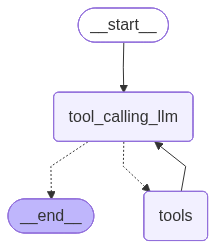

In [17]:
from PIL import Image
from IPython.display import display
from io import BytesIO

png_bytes = graph.get_graph().draw_mermaid_png()
img = Image.open(BytesIO(png_bytes))
display(img)
